In [2]:
!pip install transformers
!pip install accelerate -U

In [3]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
!pip install xlrd

  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)


In [6]:
ROOT_DIR = '/kaggle/input/testss/'

df= pd.read_excel(ROOT_DIR + "Train.xls")

df= df.sample(frac=1.0, random_state=42)

df.head()

,PhraseId,Phrase,Sentiment
19756,19757,I’m stuckI can’t get professional help and I f...,3
2240,2241,"oh boy, where to start! i guess my biggest str...",0
20681,20682,Is it possible I'm living a nightmare/in hellI...,3
3096,3097,work! we are short handed and so all the work ...,0
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1


In [7]:
value_to_name = {
    0: "Sadness",
    1: "Happiness",
    2: "Depression",
    3: "Suicide",
    4: "Neutral",
}

df["Sentiment_name"] = df["Sentiment"].map(value_to_name.get)


In [8]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,3,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",0,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,3,Suicide
3096,3097,work! we are short handed and so all the work ...,0,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1,Happiness


In [9]:
labels = df['Sentiment_name'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Suicide', 'Sadness', 'Happiness', 'Depression', 'Neutral']

In [10]:
for key, value in enumerate(labels):
    print(value)

Suicide
Sadness
Happiness
Depression
Neutral


In [12]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [13]:
label2id

{'Suicide': 0, 'Sadness': 1, 'Happiness': 2, 'Depression': 3, 'Neutral': 4}

In [14]:
id2label

{0: 'Suicide', 1: 'Sadness', 2: 'Happiness', 3: 'Depression', 4: 'Neutral'}

In [15]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,3,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",0,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,3,Suicide
3096,3097,work! we are short handed and so all the work ...,0,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1,Happiness


In [16]:
df["Sentiment"]=df.Sentiment_name.map(lambda x: label2id[str(x).strip()])

In [17]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,0,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",1,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,0,Suicide
3096,3097,work! we are short handed and so all the work ...,1,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,2,Happiness


<Axes: xlabel='Sentiment_name'>

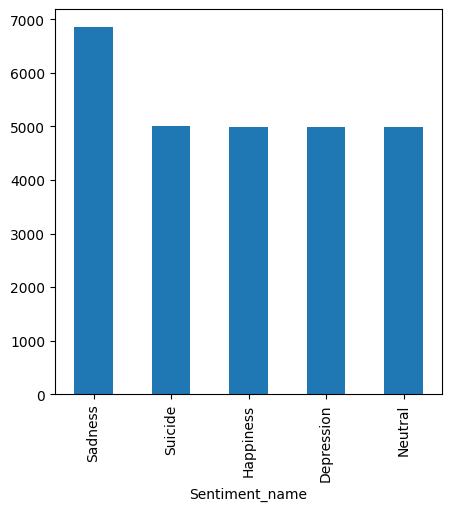

In [18]:
df.Sentiment_name.value_counts().plot(kind='bar', figsize=(5,5))

In [19]:
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased", max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Splitting df عشان يجرب داتا من نفس الداتا سيت عشان يشوف الاكيورسي


In [21]:
SIZE= df.shape[0]

train_texts= list(df.Phrase[:SIZE//2])

val_texts=   list(df.Phrase[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.Phrase[(3*SIZE)//4:])

train_labels= list(df.Sentiment[:SIZE//2])

val_labels=   list(df.Sentiment[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.Sentiment[(3*SIZE)//4:])

In [22]:
len(train_texts)


13424

In [23]:
len(train_texts), len(val_texts), len(test_texts)

(13424, 6712, 6712)

In [25]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [26]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [27]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training

In [28]:
from transformers import TrainingArguments, Trainer

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [30]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./model',  # Adjusted to a relative path
    do_train=True,
    do_eval=True,
    # The number of epochs, defaults to 3.0
    num_train_epochs=2,  # Reduced to 2 epochs to save time
    per_device_train_batch_size=8,  # Reduced batch size to save memory
    per_device_eval_batch_size=8,   # Reduced batch size to save memory
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='epoch',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=100,  # Adjusted logging steps to reduce output
    evaluation_strategy="epoch",
    eval_steps=100,
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    disable_tqdm=False,
)




In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.084500,0.193931,0.960965,0.961832,0.961733,0.961961
2,0.030800,0.190202,0.966329,0.966953,0.967858,0.966190


Checkpoint destination directory ./model/checkpoint-839 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1678, training_loss=0.05763637920102289, metrics={'train_runtime': 1649.7016, 'train_samples_per_second': 16.274, 'train_steps_per_second': 1.017, 'total_flos': 7064195888873472.0, 'train_loss': 0.05763637920102289, 'epoch': 2.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

In [38]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast


In [39]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [42]:
text = "its so hot today and i want to take a bath"
predict(text)

(tensor([[1.4308e-04, 5.3825e-04, 2.8027e-05, 3.2661e-05, 9.9926e-01]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(4, device='cuda:0'),
 'Neutral')

## Save model for inference

In [43]:
model_path = "sentemintal_anal_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('sentemintal_anal_model/tokenizer_config.json',
 'sentemintal_anal_model/special_tokens_map.json',
 'sentemintal_anal_model/vocab.txt',
 'sentemintal_anal_model/added_tokens.json',
 'sentemintal_anal_model/tokenizer.json')

## Re-Load saved model for inference

In [44]:
model_path = "sentemintal_anal_model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [61]:
nlp("i am had the best night on my life yesterday")


[{'label': 'Happiness', 'score': 0.9989140033721924}]

In [49]:
nlp("i am so sick of this")

[{'label': 'Sadness', 'score': 0.9996380805969238}]

In [57]:
nlp("i wanna kill my self")

[{'label': 'Suicide', 'score': 0.9996005892753601}]